In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# Load and inspect the data
email_tbl = pd.read_csv('email/email_table.csv')
email_opened_tbl = pd.read_csv('email/email_opened_table.csv')
link_clicked_tbl = pd.read_csv('email/link_clicked_table.csv')

In [3]:
email_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
email_opened_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [5]:
link_clicked_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
email_id    2119 non-null int64
dtypes: int64(1)
memory usage: 16.6 KB


Q. What percentage of users opened the email and what percentage clicked on the link
within the email?

In [6]:
percent_opened = (email_tbl[email_tbl.email_id.isin(email_opened_tbl.email_id)].shape[0] / float(email_tbl.shape[0]))*100
percent_clicked = (email_tbl[email_tbl.email_id.isin(link_clicked_tbl.email_id)].shape[0] / float(email_tbl.shape[0]))*100
print "Percent opened {0}".format(percent_opened)
print "Percent clicked {0}".format(percent_clicked)

Percent opened 10.345
Percent clicked 2.119


Q. The VP of marketing thinks that it is stupid to send emails to a random subset and in a
random way. Based on all the information you have about the emails that were sent, can
you build a model to optimize in future email campaigns to maximize the probability of
users clicking on the link inside the email?

{'boxes': [<matplotlib.lines.Line2D at 0xc78fa90>],
 'caps': [<matplotlib.lines.Line2D at 0xc564748>,
 'fliers': [<matplotlib.lines.Line2D at 0xc5757f0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xc575278>],
 'whiskers': [<matplotlib.lines.Line2D at 0xc78fba8>,
  <matplotlib.lines.Line2D at 0xc5641d0>]}

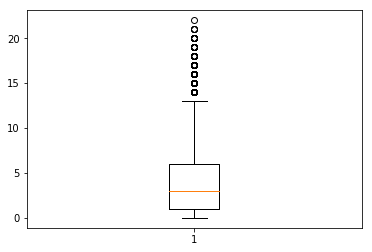

In [7]:
# Create a boxplot of past user purchases
plt.boxplot(email_tbl.user_past_purchases)

In [8]:
# Remove outliers
non_outliers = email_tbl[email_tbl.user_past_purchases < 12]

In [9]:
# Add a 'link_clicked' column to the dataframe
clicked_emails = set(link_clicked_tbl.email_id)
non_outliers['link_clicked'] = non_outliers.email_id.apply((lambda x: 1 if x in clicked_emails else 0))

C:\Users\daryleserrant\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [10]:
non_outliers.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,link_clicked
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,1
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0


In [11]:
non_outliers.user_country.value_counts(normalize=True)

US    0.600942
UK    0.199662
FR    0.099754
ES    0.099642
Name: user_country, dtype: float64

In [12]:
# Over 90% of the user base is in the US and UK. For now, we'll simplify the problem and focus only on users in the US and UK.
us_uk_emails = non_outliers[non_outliers.user_country.isin(['US','UK'])]

In [13]:
# Create a binary column 'country_US' to indiciate if the user is in the US or UK
us_uk_emails['country_US'] = us_uk_emails.user_country.apply((lambda x: 1 if x == 'US' else 0))

C:\Users\daryleserrant\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:
# Create a binary column for the email text. Value is 1 for short_emails, 0 for long emails
us_uk_emails['is_short'] = us_uk_emails.email_text.apply((lambda x: 1 if x == 'short_email' else 0))

C:\Users\daryleserrant\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
# Create a binary column for email version. Value is 1 for generic emails, 0 for personalized emails
us_uk_emails['is_generic'] = us_uk_emails.email_version.apply((lambda x: 1 if x == 'generic' else 0))

C:\Users\daryleserrant\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [16]:
us_uk_emails[us_uk_emails['link_clicked'] == 1].hour.value_counts(normalize=True)

10    0.107761
9     0.105528
11    0.095477
12    0.078169
8     0.077052
7     0.068677
6     0.060302
5     0.054160
13    0.053043
14    0.044668
15    0.044109
4     0.041318
3     0.040759
16    0.030709
2     0.028476
1     0.024567
17    0.017309
18    0.010609
19    0.006700
23    0.003350
20    0.003350
21    0.001675
22    0.001675
24    0.000558
Name: hour, dtype: float64

In [17]:
# Very few people who click on the email links do so during the evening hours. We'll therefore lump these variables into a
# a category called EVENING to reduce the number of dummy variables to create for the model.
evening_hours = [19,20,21,22,23,24]
us_uk_emails['hour_sent'] = us_uk_emails.hour.apply((lambda x: 'EVENING' if x in evening_hours else str(x)))

C:\Users\daryleserrant\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# Create dummy variables for the weekday and hour columns
weekday_dummies = pd.get_dummies(us_uk_emails.weekday,prefix='weekday').drop('weekday_Sunday',axis=1)
hour_dummies = pd.get_dummies(us_uk_emails.hour_sent,prefix='hour_sent').drop('hour_sent_EVENING',axis=1)

In [19]:
# Create the feature matrix
df = us_uk_emails[['user_past_purchases','is_short','is_generic','link_clicked']]
df = df.join(weekday_dummies)
df = df.join(hour_dummies)
y = df.pop('link_clicked').values
X = df.values

In [20]:
'''
Since a very tiny percentage of users who clicked the link in the email, we will undersample the majority class to balance
the dataset.
'''
def undersample(X,y):
    majority_X = X[y == 0]
    majority_y = y[y == 0]
    minority_y = y[y == 1]
    minority_X = X[y == 1]
    minority_size = y[y == 1].shape[0]
    
    inds = np.arange(minority_size)
    samples = np.random.choice(inds, minority_size,replace=False)
    
    undersampled_X = np.concatenate((majority_X[samples],minority_X), axis=0)
    undersampled_y = np.concatenate((majority_y[samples],minority_y), axis=0)
    return (undersampled_X, undersampled_y)

In [21]:
# Split the data into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)

In [22]:
# Undersample the training data to balance the classes
X_sub,y_sub = undersample(X_train,y_train)

In [23]:
# Train and tune a random forest classifer 
rf_params = {'n_estimators':[20,30,40,50],
             'criterion':['gini','entropy'],
             'max_features':['auto','log2'],
             'min_samples_leaf':[1,2,5,10,11,12,13,14,15],
             'min_samples_split':[2, 3, 5, 7,10]}
rf_clf = GridSearchCV(RandomForestClassifier(),rf_params, scoring = 'roc_auc')
rf_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40, 50], 'max_features': ['auto', 'log2'], 'min_samples_split': [2, 3, 5, 7, 10], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 5, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [24]:
rf_clf.best_params_

{'criterion': 'gini',
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 40}

In [25]:
rf_clf.best_score_

0.7087190485612529

In [26]:
# Train and tune a logistic regression classifer 
lr_params = {'C':[0.1,0.2, 0.3, 0.4]}
lr_clf = GridSearchCV(LogisticRegression(),lr_params,scoring='roc_auc')
lr_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.2, 0.3, 0.4]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [27]:
lr_clf.best_params_

{'C': 0.1}

In [28]:
lr_clf.best_score_

0.70400566736389847

In [29]:
# Train and tune a Gradient Boosting classifer 
gbc_params = {'learning_rate':[0.1,0.2,0.3,0.4],
              'n_estimators':[100,200],
              'min_samples_leaf':[1,5,7,8],
              'min_samples_split':[2, 3, 5, 7,10],
              'max_features':['auto','log2']
             }
gbc_clf = GridSearchCV(GradientBoostingClassifier(),gbc_params,scoring='roc_auc')
gbc_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'min_samples_split': [2, 3, 5, 7, 10], 'learning_rate': [0.1, 0.2, 0.3, 0.4], 'max_features': ['auto', 'log2'], 'min_samples_leaf': [1, 5, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [30]:
gbc_clf.best_params_

{'learning_rate': 0.1,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 5,
 'n_estimators': 100}

In [31]:
gbc_clf.best_score_

0.70944454651666766

In [32]:
# Train and tune a Support Vector classifer 
svc_params = {'kernel':['rbf','sigmoid','linear','poly'],
              'C':[0.1,0.5,1,5,10],
              'degree':[1,3,5],
              'coef0':[0.5,0.6,0.7]
             }
svc_clf = GridSearchCV(SVC(),svc_params,scoring='roc_auc')
svc_clf.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 'C': [0.1, 0.5, 1, 5, 10], 'coef0': [0.5, 0.6, 0.7], 'degree': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [33]:
svc_clf.best_params_

{'C': 1, 'coef0': 0.5, 'degree': 1, 'kernel': 'rbf'}

In [34]:
svc_clf.best_score_

0.70696419149377199

In [35]:
# Test models on the validation set
lr = LogisticRegression(C=0.1)
lr.fit(X_sub,y_sub)
lr_pred = lr.predict(X_val)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_auc = auc(lr_fpr, lr_tpr)

rf = RandomForestClassifier(criterion = 'entropy',
                            max_features = 'auto',
                            min_samples_leaf = 12,
                            min_samples_split = 7,
                            n_estimators= 40)
rf.fit(X_sub,y_sub)
rf_pred = rf.predict(X_val)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_auc = auc(rf_fpr, rf_tpr)

gbc = GradientBoostingClassifier(learning_rate= 0.1,
                                 max_features ='log2',
                                 min_samples_leaf = 5,
                                 min_samples_split = 2,
                                 n_estimators =100)
gbc.fit(X_sub,y_sub)
gbc_pred = gbc.predict(X_val)
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_val, gbc_pred)
gbc_recall = recall_score(y_val, gbc_pred)
gbc_auc = auc(gbc_fpr, gbc_tpr)

svc = SVC(C=1, coef0=0.6, degree=1,kernel='poly')
svc.fit(X_sub,y_sub)
svc_pred = svc.predict(X_val)
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_val, svc_pred)
svc_recall = recall_score(y_val, svc_pred)
svc_auc = auc(svc_fpr, svc_tpr)

In [36]:
print "Logistic Regression (AUC, Recall) {0}".format((lr_auc,lr_recall))
print "Random Forest (AUC, Recall) {0}".format((rf_auc,rf_recall))
print "Gradient Boosting Classifier (AUC, Recall) {0}".format((gbc_auc,gbc_recall))
print "Support Vector Classifier (AUC, Recall) {0}".format((svc_auc,svc_recall))

Logistic Regression (AUC, Recall) (0.6664992452589148, 0.67179487179487174)
Random Forest (AUC, Recall) (0.64289988670479037, 0.71794871794871795)
Gradient Boosting Classifier (AUC, Recall) (0.64684706491445709, 0.68205128205128207)
Support Vector Classifier (AUC, Recall) (0.65334355343533268, 0.64102564102564108)


In [37]:
# THe Random Forest classifer appears to be the best. Let's check out it's confusion matrix.
confusion_matrix(y_val,rf_pred)

array([[4331, 3296],
       [  55,  140]])

Q. By how much do you think your model would improve click through rate ( defined as # of
users who click on the link / total users who received the email). How would you test
that?  
  
**I would expect at least a 1% improvement in click through rate. I would use an A/B test to test this assumption. I would randomly split the users into a control group and a test group and launch another email campaign for both groups. Emails will be sent out in a random way in the first group, and the model will be used to target the emails to users in the test group. At the end of the campaign, I will run a statistical test for significance.
**

Q. Did you find any interesting pattern on how the email campaign performed for different
segments of users? Explain.

** I noticed that the ideal times for users who click on the link in the email vary by country and by day of the week. See the bar plots below. **

In [38]:
def plot_hourly_counts(ax, df, atitle):
    email_hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    email_counts = df.groupby(['hour','link_clicked'])['email_id'].count().to_dict()

    counts_clicked = []
    counts_noclicked = []
    bar_width = 0.35
    ind = np.arange(len(email_hours))

    for e in email_hours:
        if (e,1) in email_counts:
            counts_clicked.append(email_counts[(e,1)])
        else:
            counts_clicked.append(0)
        if (e,0) in email_counts:
            counts_noclicked.append(email_counts[(e,0)])
        else:
            counts_noclicked.append(0)
    ax.bar(ind,counts_clicked,bar_width,color='r',label='clicked')
    ax.bar(ind+bar_width,counts_noclicked,bar_width,color='g',label='not clicked')
    ax.set_title(atitle)

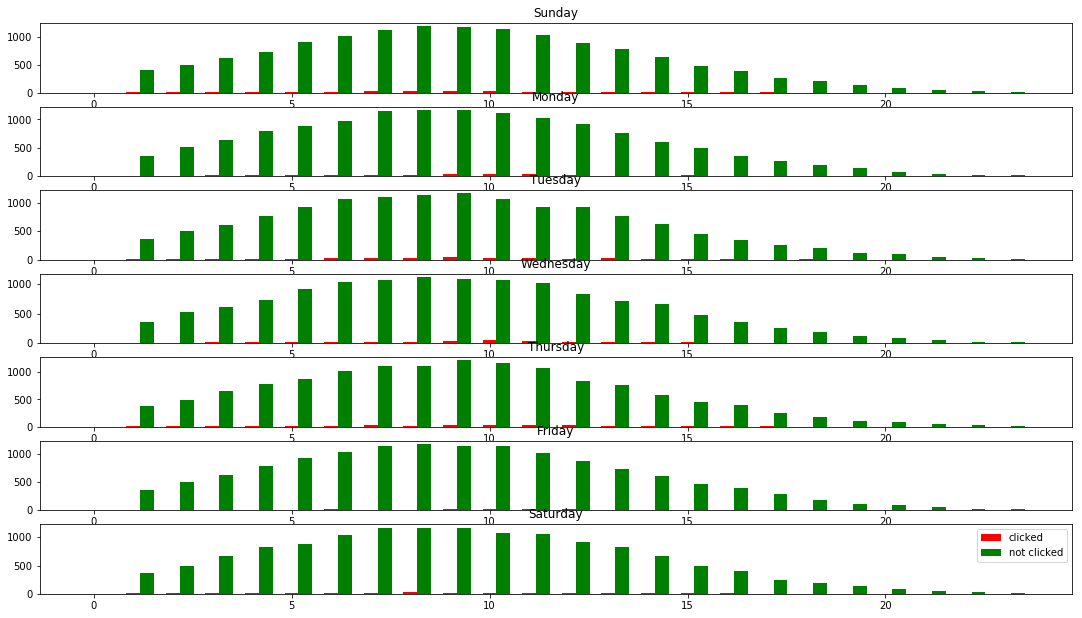

In [39]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
for i in range(7):
    df = non_outliers[non_outliers.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

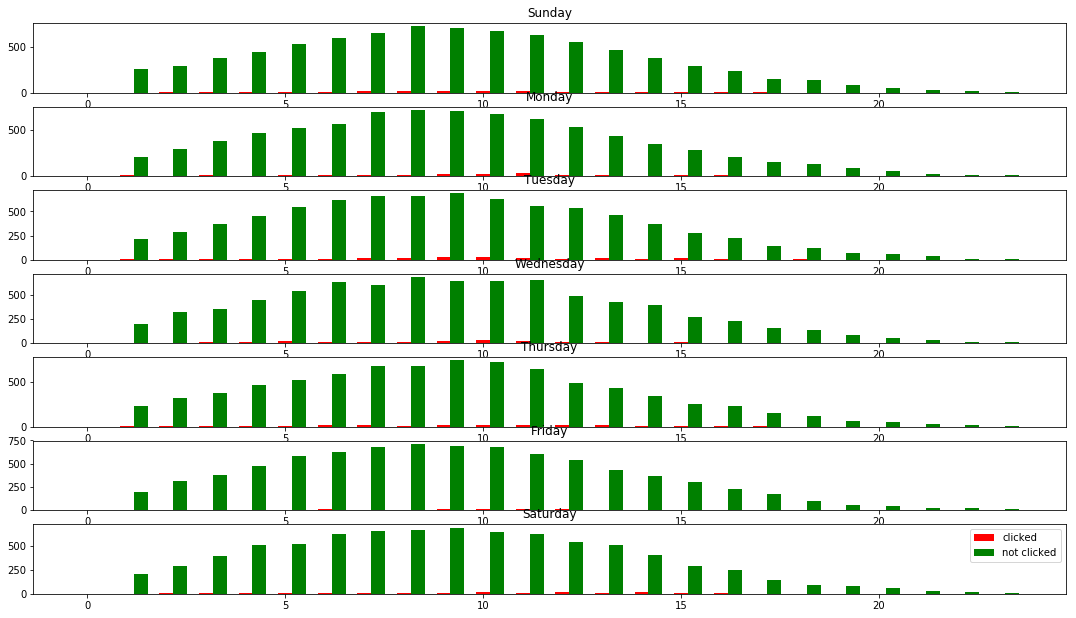

In [40]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'US']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

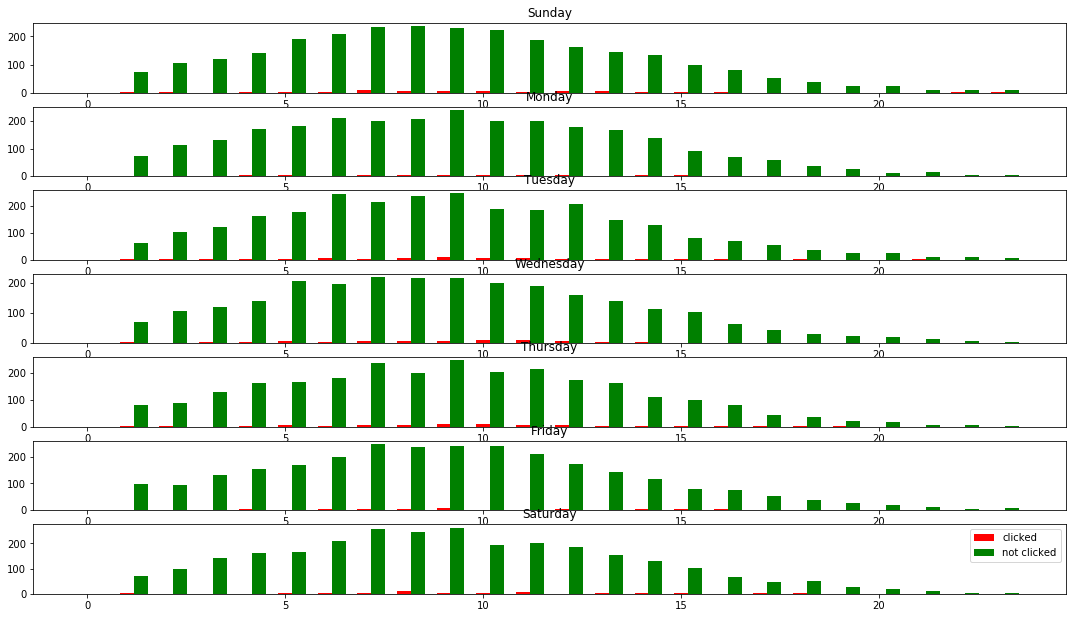

In [41]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'UK']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

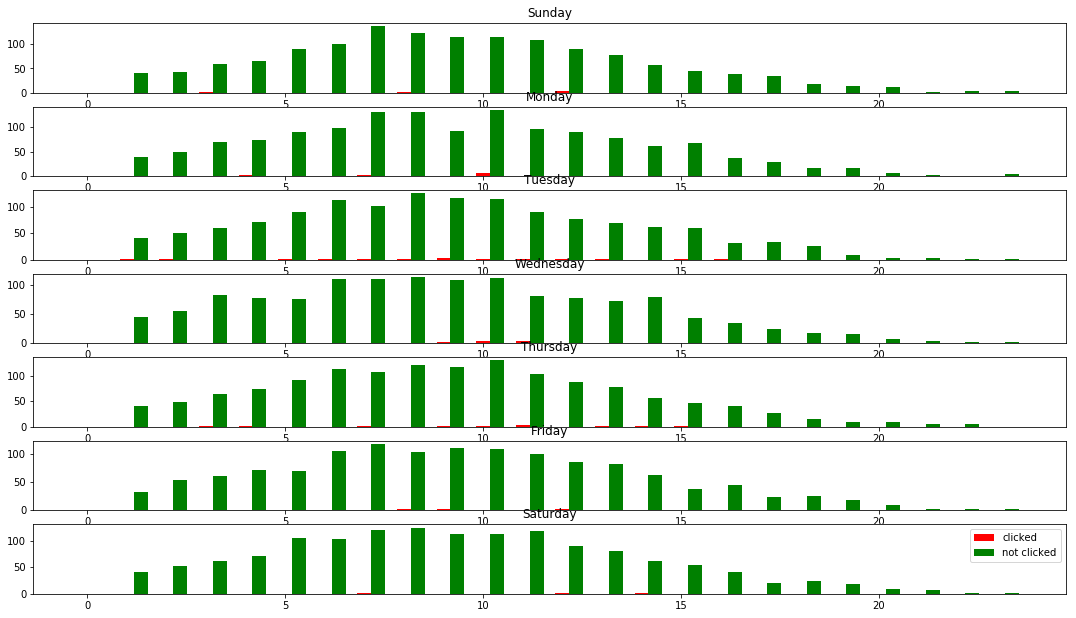

In [42]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'ES']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

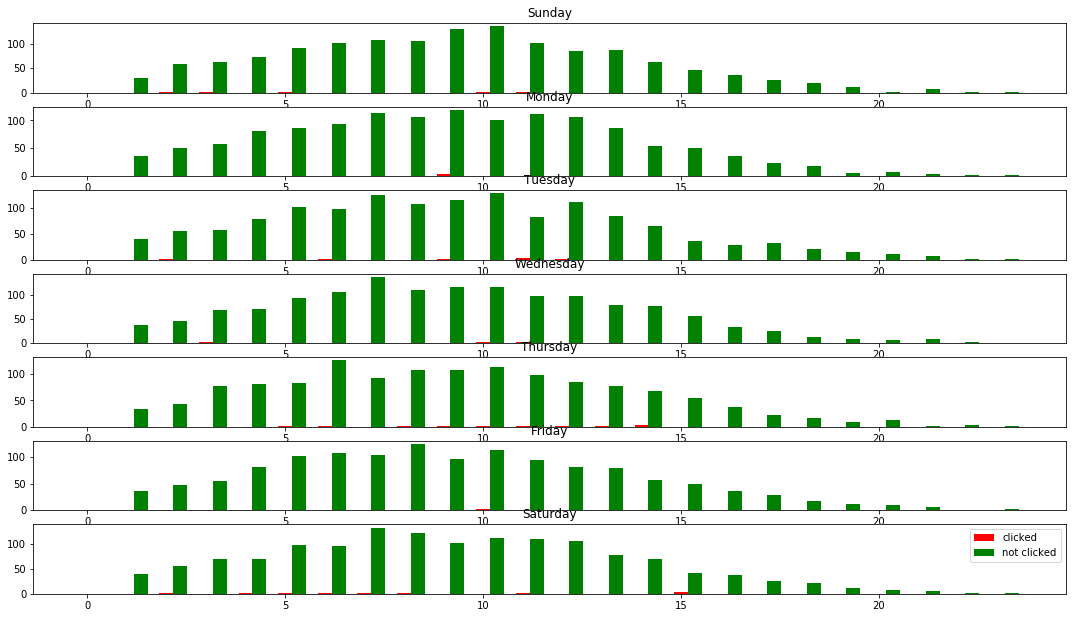

In [43]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'FR']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()